In [1]:
from collections import Counter

import numpy as np
import collections
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
from collections import OrderedDict 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
movie_df = pd.read_csv(r'data/data_analysis.csv')

In [3]:
movie_df.columns

Index(['imdb_id', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'num_user_for_reviews',
       'language', 'country', 'content_rating', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes'],
      dtype='object')

# Feature Engineering and pre-data processing
- One Hot encoding:
    - Genres
    - Director
    - Protagonist

**Genre**

In [4]:
mlb = MultiLabelBinarizer()
genres = movie_df.genres.str.split("|")
encoded_genres = pd.DataFrame(mlb.fit_transform(genres), columns=mlb.classes_, index=movie_df.index)
encoded_genres

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3874,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3875,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3876,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


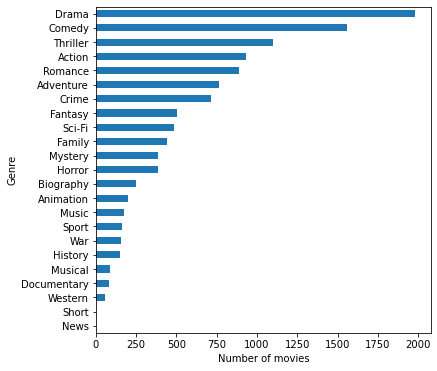

In [5]:
count_encoded_genres = encoded_genres.sum().sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(6,6))
count_encoded_genres.plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('Number of movies')
ax.set_ylabel('Genre')
plt.show()

We can group togheter similar genres, in order to decrease the number of columns

In [6]:
# Mystery|Thriller|Horror
sum_gen = encoded_genres[['Mystery','Thriller','Horror']].sum(axis=1)
encoded_genres['Mystery_Thriller_Horror'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['Mystery','Thriller','Horror'], axis=1) #drop other

#Sci-Fi|Fantasy
sum_gen = encoded_genres[['Sci-Fi','Fantasy']].sum(axis=1)
encoded_genres['Sci-Fi_Fantasy'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['Sci-Fi','Fantasy'], axis=1) #drop other

#Family|Animation
sum_gen = encoded_genres[['Family','Animation']].sum(axis=1)
encoded_genres['Family_Animation'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['Family','Animation'], axis=1) #drop other

#Action|Adventure
sum_gen = encoded_genres[['Action','Adventure']].sum(axis=1)
encoded_genres['Action_Adventure'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['Action','Adventure'], axis=1) #drop other

#History|War
sum_gen = encoded_genres[['History','War']].sum(axis=1)
encoded_genres['History_War'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['History','War'], axis=1) #drop other


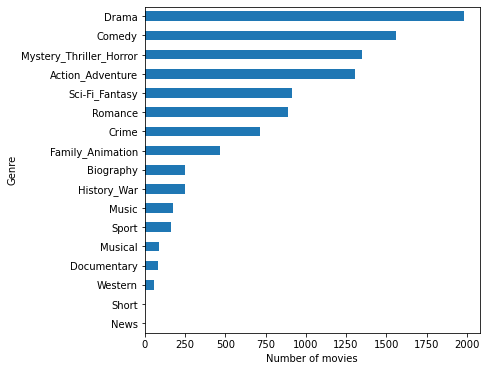

In [7]:
count_encoded_genres = encoded_genres.sum().sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(6,6))
count_encoded_genres.plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('Number of movies')
ax.set_ylabel('Genre')
plt.show()

At this point we can put togheter genres which are not common:

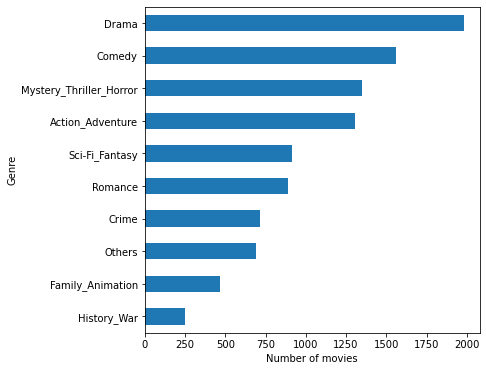

In [8]:
#Other
other = ['Biography','Music','Sport','Documentary','Musical','Western','Short','News']
sum_gen = encoded_genres[other].sum(axis=1)
encoded_genres['Others'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(other, axis=1) #drop other

# Add genres columns to movie_df
movie_df = movie_df.merge(encoded_genres,how='left', left_index=True, right_index=True)
#movie_df = movie_df.drop('genres', axis=1) #drop genre

count_encoded_genres = encoded_genres.sum().sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(6,6))
count_encoded_genres.plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('Number of movies')
ax.set_ylabel('Genre')
plt.show()

## Director

In [9]:
group_director = movie_df.groupby('director_name') # group the database for the director
directors = list(movie_df.director_name.values) #director list
directors_unique =list(OrderedDict.fromkeys(directors)) # no duplicates

#number of movies for each director
counter = collections.Counter(directors)
results = [directors.count(x) for x in directors_unique] #number of films
directors = pd.DataFrame([directors_unique, results], index=['director', 'num_movies']).T
directors = directors.set_index('director')

In the regression, we cannot use variables which are consequnces, as movie_facebook_likes. However, we can use them to understand how much a director is famous. If a film has a lot of likes, its director will probably earn a good reputation.

Same reasoning for imdb_score

In [10]:
# mean movie_facebook_likes for the movies did by that director
num_likes = group_director.mean().movie_facebook_likes
directors = directors.merge(num_likes,how='left', left_index=True, right_index=True)

# mean movie_facebook_likes for the movies did by that director
score = group_director.mean().imdb_score
directors = directors.merge(score, how='left', left_index=True, right_index=True)

directors.head(10)

,num_movies,movie_facebook_likes,imdb_score
director,,,
James Mangold,8,12875.000000,7.075000
Jim Abrahams,1,16000.000000,7.800000
Randal Kleiser,2,0.000000,6.200000
John Landis,3,4889.666667,6.966667
Harold Ramis,8,4855.750000,6.550000
Nancy Walker,1,1000.000000,4.500000
Michael Apted,6,4392.000000,6.516667
Brian De Palma,10,2165.500000,6.600000
David Lynch,4,9000.000000,7.700000


Using these three features, we can create a ranking for the directors. We consider 10 levels. If a director is in level 10, he is really important: he has done a lot of movies with high ranking. 

In order to do that, we 
- trasform this variables in values between 0 and 1
- do the mean of each column (same weight for each feature)
- create 10 groups

In [12]:
#we divide wach value for the max of that column in order to have values between 0 and 1
directors.num_movies = directors.num_movies/directors.num_movies.max()
directors.movie_facebook_likes = directors.movie_facebook_likes/directors.movie_facebook_likes.max()
directors.imdb_score = directors.imdb_score/directors.imdb_score.max()

#we consider that each column has the same weight and we do the mean 
directors['mean_'] = directors.num_movies*1/3 + directors.movie_facebook_likes*1/3 + directors.imdb_score*1/3
massimo = directors.mean_.max()
directors['director_rank'] = [int(x) for x in directors.mean_/massimo*10]

directors = directors.sort_values(['director_rank','num_movies'], ascending=False)

directors.head(10)

,num_movies,movie_facebook_likes,imdb_score,mean_,director_rank
director,,,,,
Christopher Nolan,0.347826,0.791031,0.979651,0.706169,10
Steven Spielberg,1,0.140392,0.874115,0.671502,9
Stephen Chbosky,0.0434783,1.000000,0.930233,0.657904,9
Damien Chazelle,0.0434783,0.984733,0.988372,0.672194,9
Clint Eastwood,0.826087,0.107555,0.837821,0.590488,8
Martin Scorsese,0.695652,0.142176,0.890988,0.576272,8
Quentin Tarantino,0.347826,0.412214,0.953488,0.571176,8
Morten Tyldum,0.0869565,0.717557,0.912791,0.572435,8
Alex Garland,0.0434783,0.832061,0.895349,0.590296,8


In [13]:
# merge two dataset togheter
movie_df = pd.merge(left=movie_df, right=directors.director_rank, left_on='director_name', right_on='director')

,imdb_id,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,Crime,Drama,Romance,Mystery_Thriller_Horror,Sci-Fi_Fantasy,Family_Animation,Action_Adventure,History_War,Others,director_rank
0,tt0035423,James Mangold,125.0,123.0,446.0,821.0,Natasha Lyonne,20000.0,47095453.0,Comedy|Fantasy|Romance,...,0,0,1,0,1,0,0,0,0,5
1,tt0118887,James Mangold,131.0,120.0,446.0,1000.0,Sylvester Stallone,22000.0,44886089.0,Crime|Drama|Thriller,...,1,1,0,1,0,0,0,0,0,5
2,tt0172493,James Mangold,133.0,127.0,446.0,898.0,Clea DuVall,11000.0,28871190.0,Biography|Drama,...,0,1,0,0,0,0,0,0,1,5
3,tt0309698,James Mangold,136.0,91.0,446.0,660.0,Rebecca De Mornay,1000.0,51475962.0,Mystery|Thriller,...,0,0,0,1,0,0,0,0,0,5
4,tt0358273,James Mangold,291.0,153.0,446.0,154.0,Dallas Roberts,523.0,119518352.0,Biography|Drama|Music|Romance,...,0,1,1,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3873,tt4219836,Sara Newens,18.0,80.0,0.0,0.0,Xinhua Jiang,0.0,5858.0,Documentary,...,0,0,0,0,0,0,0,0,1,4
3874,tt4263482,Robert Eggers,425.0,92.0,22.0,159.0,Kate Dickie,648.0,25138292.0,Horror|Mystery,...,0,0,0,1,0,0,0,0,0,5
3875,tt4786282,David F. Sandberg,159.0,81.0,26.0,300.0,Amiah Miller,2000.0,56536016.0,Horror,...,0,0,0,1,0,0,0,0,0,3
3876,tt4824308,Harold Cronk,29.0,120.0,18.0,295.0,Robin Givens,634.0,20773070.0,Drama,...,0,1,0,0,0,0,0,0,0,2
